# Schelling and The Pursuit of Happyness

In this notebook, we will try and propose a model that predicts when a relocation - in the realm of the Schelling model - is successiful.

**NOTA**: the execution of this notebook implies running CPU-heavy and memory-heavy simulations and grid searches, that can be **extremely time-consuming**. However, after some synthetic data is generated, the notebook will save a checkpoint that can be retrieved easily.

## Library installing

For this task, we will need to install some libraries.
- [MESA](https://mesa.readthedocs.io/en/stable/) is used for agent-based modelling.
- [Scikit-Learn](https://scikit-learn.org/stable/) provides machine learning models and utility functions.
- [Scikit-Optimize](https://scikit-optimize.github.io/) implements Bayesian optimization for Scikit-Learn.
- [XGBoost](https://xgboost.readthedocs.io/en/stable/), [CatBoost](https://catboost.ai) and [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/) contain two implementations of gradient boosted trees.
- [imodels](https://github.com/csinva/imodels) contains implementations of some state-of-the art explainable models, most notably [FIGS](https://bair.berkeley.edu/blog/2022/06/30/figs/).

We will also need [Pandas](https://pandas.pydata.org) to use the DataFrame data structure, [Matplotlib](https://matplotlib.org/) and [Graphviz](https://graphviz.org/) to plot some graphs.

In [ ]:
! conda install scikit-learn pandas matplotlib graphviz -y
! conda install -c conda-forge mesa xgboost catboost lightgbm scikit-optimize -y
! pip install imodels

## MESA-based simulation

We create a standard Schelling model with a mild-random policy, where when an agent is not happy it moves to a cell where its homophily is satisfied. The implementation can be found in `schelling/model.py` and `schelling/agent.py`.

We run several simulations, with various combinations of parameters. In particular, we use:
- `side`: Size of the grid. 8x8 (classical chessboard) and 20x20 (bigger, hence more complex dynamic may emerge)
- `density`:  Density (percentage of the total cells that are populated). From 2% (grid is almost empty, hence the segregation should be faster) to 66% (two thirds of the cells are occupied).
- `minority_pc`: Minority percentage (percentage of agents that are in the minority class):  From 1/4 (mild prevalence of the majority class) to 1/2 (equality between the two classes).
- `homophily`: minimal fraction of the neighbors that an agent needs of its own type to be considered happy. From 1/8 (extremely tolerant) to 9/8 (extremely racist).

For each parameter configuration, we store the `relocation_dataset` of each agent, updated each time an agent relocates from position `start` to position `end`, with the following features:
- Agent-level features:
    - `steps`: Number of steps passed in `start`.
    - `relocations`: Number of previous relocations.
    - `segregation`: Current value of the segregation at the moment of relocation.
    - `segregation_min`, `segregation_max`, `segregation_avg`: Minimum, maximum and average segregation relative to the period passed in `start`.
- Location-level features:
    - `x`, `y`: Coordinates of the location.
    - `density`: Number of occupied cells in the neighborhood of the location.
    - `segregation_minority`, `segregation_majority`: Segregation of the minority/majority class in the location.`
- Target label:
    - `happyness_duration`: Fraction of the total number of simulation steps passed in `end` by the agent.

In order to obtain a big number of records, we run every simulation 5 times, for a maximum of 500 iterations. For reproducibility, we set the random number generator with a fixed seed.

In [ ]:
import numpy as np

parameters = {
    "side": [10, 20],
    "density": np.arange(2 / 100, 66 / 100, 1 / 5),
    "minority_pc": np.arange(1 / 4, 1 / 2, 1 / 8),
    "homophily": np.arange(1 / 8, 9 / 8, 1 / 8),
}

iterations = 5
max_steps = 500
random_seed = 0

To run the simulation, we use the MESA library's `batch_run` function.

**NOTA**: The simulation is very time-consuming, so in the next cell it will be possible to download the pre-computed dataset from GitHub without the need of running this cell.

In [ ]:
import pandas as pd
import random
from mesa.batchrunner import batch_run

from schelling.model import SchellingModel

random.seed(random_seed)

results = batch_run(
    SchellingModel,
    parameters=parameters,
    number_processes=None,
    iterations=iterations,
    max_steps=max_steps,
    display_progress=True
)
df = pd.concat((result["relocation_dataset"] for result in results if result is not None), ignore_index=True)
df.to_csv("./dataset.csv.gz", compression="gzip")
df

### Transformation into a classification problem

We want to discretize the `happyness_duration` target variable in order to solve a classification problem. By plotting an histogram of the variable discretized with 30 bins, we can observe how the distribution is very skewed, with a happyness duration that can be either very short (less than 1%) or very long (around 100%). In practice, this can be explained by the fact that a configuration can induce in the agent basically three behaviors:
1) The agent is often unhappy and relocates continuously.
2) The agent is happy after few relocations and stays for the whole run.
3) "Something in the middle", with some relocations that are more successiful than others.

Dataset contains 3302455 records


<AxesSubplot: >

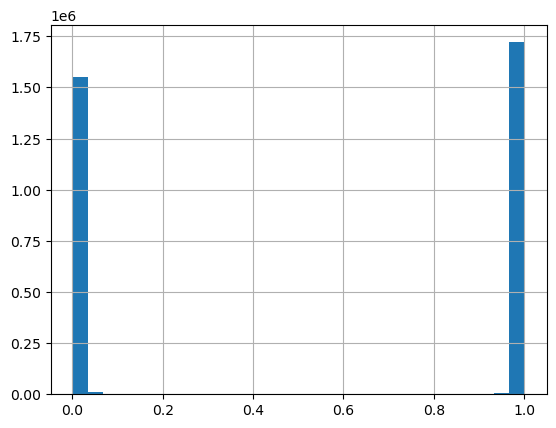

In [1]:
import pandas as pd

dataset_url = "https://github.com/karjudev/geospatial-analytics/blob/master/dataset.csv.gz?raw=true"
# Uncomment if you want to use a local copy
# dataset_url = "./dataset.csv.gz"

df = pd.read_csv(dataset_url, compression="gzip")
print("Dataset contains", len(df), "records")

df["happyness_duration"].hist(bins=30)

The choices we can make to discretize the variables are basically two:

- Equal-width binning: Find the threshold so that the range of values assigned to classes "short" and "long" are of the same width.
- Equal-size binning: Find the threshold so that the ranges have approximately the same number of examples.

Both strategies have pros and cons, so we try it in practice in order to better understand the impact of each on our dataset:

In [ ]:
print("Equal width")
eq_width, eq_width_bins = pd.cut(df["happyness_duration"], bins=2, labels=False, duplicates="drop", retbins=True)
display(eq_width_bins)
display(eq_width.value_counts(normalize=True))

print("Equal size")
eq_size, eq_size_bins = pd.qcut(df["happyness_duration"], q=2, labels=False, duplicates="drop", retbins=True)
display(eq_size_bins)
display(eq_size.value_counts(normalize=True))

With equal-size binning we have a more balanced distribution of positive and negative examples, but the threshold from "short" to "long" is fixed around 0.99. In this way we are assigning *all* the relocations that lasted less than 99% of the simulation steps to the negative class.

For this reason, at the cost of having a slightly imbalanced dataset (53%-47% versus 50%-50%), we choose equal-width binning as our discretization strategy.

In [ ]:
df["happyness_duration"] = eq_width

### Train-validation-test split

Let $\mathbf{X}$ be the features matrix and $\mathbf{y}$ be the target vector `happyness_duration`.

Since we have many records, in order to speed up the training we sample from $\mathbf{X}, \mathbf{y}$ a *small* training set $\mathbf{X}_\mathrm{TR}, \mathbf{y}_\mathrm{TR}$ of $2^{16} = 65 536$ records, and we call development set $\mathbf{X}_\mathrm{DV}, \mathbf{y}_\mathrm{DV}$ the remaining rows. We use stratified sampling in order to keep the same proportion of examples per class.

The training set will be used for model training and $K$-fold cross-validation, while the development set will be furtherly split into a validation set $\mathbf{X}_\mathrm{VL}, \mathbf{y}_\mathrm{VL}$ of $2^{16} = 65 536$ rows, used to evaluate the trained model on unseen data, and a test set $\mathbf{X}_\mathrm{TS}, \mathbf{y}_\mathrm{TS}$ with the rest, used in the end to obtain the final model's accuracy.

We use the implementation of stratified sampling provided by the Scikit-Learn's `train_test_split` function. To preserve reproducibility, we use the same random seed as in the previous steps.

In [ ]:
from sklearn.model_selection import train_test_split
import random

X = df.drop(columns="happyness_duration").values
y = df["happyness_duration"].values

sample_size = 2 ** 16

random_seed = 0
random.seed(random_seed)

X_train, X_dev, y_train, y_dev = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_dev, y_dev, train_size=sample_size, stratify=y_dev, random_state=random_seed)

print("Training set:", len(X_train), "rows")
print("Validation set:", len(X_val), "rows")
print("Test set:", len(X_test), "rows")

### Dataset exploration

We use Principal Component Analysis to visually explore the training set before starting the model selection. We select the first two principal component as axes, while the output class is represented with two different colors.

We are able to spot a clear separation margin between the two classes, so the classification should be easy to achieve even with a simple model.

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_r = pca.fit_transform(X_train)
plt.scatter(x=X_r[:, 0], y=X_r[:, 1], c=y_train)

## Classification models

We will benchmark a variety of machine learning models implemented by Scikit-Learn and imodels.

Since we are dealing with tabular data, the literature and a simple rule of thumb suggests to put more effort investigating tree-based models. In a preliminary phase we also tried Support Vector Machine models, but they were unable to reach the baseline and were also very time-consuming to train.

To perform an adequate model selection, we will use *Bayesian optimization* to find the optimal hyperparameter configuration. This method considers a function that takes the hyperparameter configuration, with parameters sampled from given distributions, and outputs the model's accuracy. Then it deploys global optimization to explore the search space and find the (approximate) optimum value for each hyperparameter. The algorithm is repeated 10 times, and a 4-fold cross-validation is used to assess the results with more robustness.

To ease this, we write a simple utility function.

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from skopt import BayesSearchCV

def k_fold_cv(model, hyperparameters, k=4, n_iter=10, random_seed=0):
    clf = BayesSearchCV(model, hyperparameters, n_iter=n_iter, cv=k, n_jobs=-1, random_state=random_seed)
    search = clf.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_, search.best_score_

We write a utility function also to evaluate a model's performances on the validation set:

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_accuracy(model, X_val, y_val):
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

### $K$-nearest neighbors

The most simple, but powerful model we can test predicts the class of an instance with the weighted majority class among the $K$-nearest neighbor vectors in the training set. Such an elementary model can describe very complex dynamics, but some hyperparameters have to be tuned:
- Size of the neighborhood, i.e. $K$: Number of neighbors to consider for each example.
- Way to compute the weights associated to each neighbors: `uniform` means to consider each neighbor with the same weight, while `distance` means to assign a weight proportional to the distance from the example taken into account.
- Leaf size: Number of examples that can be stored in a leaf in the specific data structure (BallTree or KDTree) used to represent the training set and speed up the queries.
- $p$-norm to use: Wether to use $L_1$, $L_2$ or some other $L_p$ norm.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
hyperparams = {
    "n_neighbors": (1, 10, "uniform"),
    "weights": ["uniform", "distance"],
    "leaf_size": (2, 1024, "uniform"),
    "p": [1, 2]
}
knn, knn_params, knn_score = k_fold_cv(model, hyperparams)
print("Accuracy with K-fold CV:", knn_score)
print("Accuracy on the validation set:", evaluate_accuracy(knn, X_val, y_val))
print("Best configuration:", knn_params)

An accuracy of 99.865% is obtained with a leaf size of 153, $K = 8$ neighbors, $L_1$ norm and distance-based weighting of the neighborhood. This result is amazing and very difficult to surpass, but comes with the drawback that $K$-NN needs to store the full training set in memory and suffers the curse of dimensionality, i.e. more features lead to poorer results. For this reason we will proceed further in our exploration, keeping $K$-NN as our baseline.

### Decision tree

A decision tree is a tree of rules automatically constructed to maximize some measure of the quantity of informations induceb by each rule. The hyparameters that we can effectively tweak are the following:
- Criterion: The qualitative measure of the splitting induced by each rule. It can be set as the Gini coefficient, as the entropy or as the log loss.
- Splitter: Rule used to select the split at each node. The algorithm can select the best split among all the possible ones or the best random split.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=random_seed)
hyperparams = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
}
dt, dt_params, dt_score = k_fold_cv(model, hyperparams)
print("Accuracy with K-fold CV:", dt_score)
print("Accuracy on the validation set:", evaluate_accuracy(dt, X_val, y_val))
print("Best configuration:", dt_params)

The accuracy of the single decision tree is slightly lower that our baseline (accuracy 99.853%) maximizing the Gini coefficient with random splits.

We can try and plot the tree to check its complexity:

In [ ]:
from sklearn.tree import plot_tree

feature_names = df.drop(columns="happyness_duration").columns.to_list()

plt.figure(figsize=(80, 60), dpi=60)
_ = plot_tree(dt, feature_names=feature_names, filled=True, fontsize=10)

The model generated on this dataset is really complex, but in principle its predictions are explainable. We want also to plot the *importance* given by the model to the different features in terms of [mean decrease in impurity](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html), in order to better understand what features dominate the decisions. To do this, we write a simple utility function that plots a feature importance DataFrame:

In [ ]:
def plot_feature_importance(importance_df, importance_name="Importance", **kwargs):
    importance_df.sort_values(by=importance_name, ascending=True, inplace=True)
    importance_df.plot(kind="barh", **kwargs)

feat_importances = pd.DataFrame(dt.feature_importances_, index=feature_names, columns=["Importance"])
plot_feature_importance(feat_importances)

The most important feature of all is the number of relocations. This can be explained with the fact that if a user did many relocations in the past, the process of segregation is more likely to be already stabilized. It's the same at the start of the process, where an agent that performed few relocations is more likely to relocate again. Density in the `end` destination is also crucial, because a denser location (a location with a higher number of agents in the neighborhood) is more likely to be in an already segregated place.

These performances are good, but we can reach a higher accuracy, at the cost of explainability, deploying two approaches: bagging and boosting of decision trees.

### Random Forest

A random forest is a forest of decision trees trained on random subsets of the training set. At prediction time, the output class associated to an examples is the majority class among the ensemble of trees. This kind of models can perform very good on tabular data, at the expense of explainability of the overall decision model.

The hyperparameters we need to tune are the following:
- Number of estimators: Number of trees to build concurrently.
- Criterion: As for the decision tree, whether to use Gini, entropy or log loss.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1, random_state=random_seed)
hyperparams = {
    "n_estimators": (1, 200, "uniform"),
    "criterion": ["gini", "entropy", "log_loss"],
}
rf, rf_params, rf_score = k_fold_cv(model, hyperparams)
print("Accuracy with K-fold CV:", rf_score)
print("Accuracy on the validation set:", evaluate_accuracy(rf, X_val, y_val))
print("Best configuration:", rf_params)

The ensemble model reaches the top performances so far (99.91% accuracy) with 157 trees built in parallel based on the measure of entropy.

To have a quick peek on the complexity of the internal trees, we plot 5 random estimators from the ensemble:

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

ensemble_indices = random.sample(range(rf.n_estimators), 5)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(80, 20))
for i, tree_id in enumerate(ensemble_indices):
    _ = plot_tree(rf.estimators_[tree_id], filled=True, feature_names=feature_names, ax=axes[i])

We can see that the ensemble is constituted of very complex models, and randomization contributes to its very high accuracy.

Let's plot a graph that synthetizes feature importance of the random forest:

In [ ]:
feat_importances = pd.DataFrame(rf.feature_importances_, index=feature_names, columns=["Importance"])
plot_feature_importance(feat_importances)

Once again, the most important features are the number of relocations and the density in `end`, so the same reasoning used for the decision tree holds.

### Gradient boosted trees

Gradient Boosting is a technique in which a sequence of prediction models are generated one after the other, giving more weight to the examples that are mis-classified in the previous iteration. At prediction time, the predictions of all the models are weighted with respect to the precision. This leads to state-of-the art results for tabular data, but many hyperparameters have to be tuned.

#### XGBoost

This is the most famous implementation of gradient boosted trees. 

The hyperparameters we need to tune are:
- Learning rate $\eta$: Learning rate for the gradient boosting.
- Maximum depth of the trees.
- Minimum loss reduction $\gamma$: Minimum reduction in the loss function needed to split a node.
- Column sample: Percentage of columns sampled for each tree.
- Regularization parameters $\alpha$, relative to the $L_1$ norm of the weights, and $\lambda$, relative to the $L_2$ norm.

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(verbosity=0, silent=True, random_seed=random_seed)
hyperparams = {
    "learning_rate": (0.0001, 1.0, "log-uniform") ,
    "max_depth": (3, 21, "uniform"),
    "gamma": (1e-16, 0.5, "log-uniform"),
    "colsample_bytree": (3/10, 1.0, "log-uniform"),
    "reg_alpha": (1e-5, 100.0, "log-uniform"),
    "reg_lambda": (1e-5, 100.0, "log-uniform"),
}
xgb, xgb_params, xgb_score = k_fold_cv(model, hyperparams)
print("Accuracy with K-fold CV:", xgb_score)
print("Accuracy on the validation set:", evaluate_accuracy(xgb, X_val, y_val))
print("Best configuration:", xgb_params)

This model does not surpas the random forest only for a 0.001%, reaching an accuracy of 99.914%. It used a column sample proportion of 33.5%, $\gamma = 0.012$, learning rate $\eta = 0.149$, maximum depth of 20, $\alpha = 0.014$ and $\lambda = 0.063$.

Again, global explainability of the model is not easy to obtain, but as done for random forest, we can plot the a subsample of 5 estimators to inspect their complexity.

In [ ]:
from xgboost import plot_tree

ensemble_indices = random.sample(range(xgb.n_estimators), 5)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(80, 60))

for i, tree_id in enumerate(ensemble_indices):
    plot_tree(xgb, num_trees=tree_id, ax=axes[i])

Even if the plot is not very clear, if we zoom we can clearly spot simpler models paired together with more complex models.

As for the other models, we can plot the feature importance, this time with respect to various metrics:
- `weight`: The number of times a feature is used for a split.
- `gain`: Average gain across all splits a feature is used in.
- `cover`: Average cover across all splits a feature is used in.
- `total_gain`, `total_cover`: Same as `gain` and `cover`, but with total gain/cover instead of average.

In [ ]:
plt.figure(figsize=(60, 60))
for i, importance_type in enumerate(["weight", "gain", "cover", "total_gain", "total_cover"]):
    importances = xgb.get_booster().get_score(importance_type=importance_type)
    feat_importances = pd.DataFrame(importances.values(), index=feature_names, columns=["Importance"])
    ax = plt.subplot(3, 2, i + 1)
    plot_feature_importance(feat_importances, ax=ax, title=f"Importance type: {importance_type}", fontsize=20)

The most important feature in terms of information gain (average and total) is, as for the previous tree-based models, the number of relocations. Other criteria evidence how the `start` and `end` coordinates are highly discriminative features and are used in a variety of splits.

### LightGBM

This implementation of gradient-boosted trees by Microsoft differs from XGBoost in various ways, most importantly in the fact that trees in the forest grow leaf-wise instead of level-wise, leading to smaller and more controllable trees.

The parameters to tune are more or less the same as the ones needed by XGBoost, but instead of the maximum depth of the trees we need to constraint the maximum number of leaves per tree.

In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=random_seed)
hyperparams = {
    "n_estimators": (1, 200, "uniform"),
    "learning_rate": (0.0001, 1.0, "log-uniform") ,
    "num_leaves": (20, 50, "uniform"),
    "colsample_bytree": (3/10, 1.0, "log-uniform"),
    "reg_alpha": (1e-5, 100.0, "log-uniform"),
    "reg_lambda": (1e-5, 100.0, "log-uniform"),
}
lgb, lgb_params, lgb_score = k_fold_cv(model, hyperparams)
print("Accuracy with K-fold CV:", lgb_score)
print("Accuracy on the validation set:", evaluate_accuracy(lgb, X_val, y_val))
print("Best configuration:", lgb_params)

LightGBM is unable to reach the same performances as XGBoost, stopping at 99.90% accuracy on the validation set. Plotting 5 random estimators in this ensemble shows far less complex decision trees with respect to the ones of the random forest and XGBoost.

In [ ]:
from lightgbm import plot_tree

ensemble_indices = random.sample(range(lgb.n_estimators), 5)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(80, 60))

for i, tree_id in enumerate(ensemble_indices):
    plot_tree(lgb, tree_index=tree_id, ax=axes[i], orientation="vertical")

The plot of feature importance shows that the most discriminative features are the coordinates and the segregation value in `start`. This suggests that our model may have found a way to distinguish a good relocation from a bad one not via a "temporal" attribute such as the number of previous relocations, but from the location-based features.

In [ ]:
feat_importances = pd.DataFrame(lgb.feature_importances_, index=feature_names, columns=["Importance"])
plot_feature_importance(feat_importances)

### CatBoost

This implementation by Yandex is the youngest of the three we proposed. It builds balanced trees, and uses *ordered boosting* in order to prevent overfitting, using a permutation-based approach to evaluate predictions on a different subset from the one used for training. It also natively supports all kind of features instead of using transformations to reduce all feature types to continuous values.

It needs more or less the same hyperparameters needed to tune XGBoost and LightGBM, with a few exceptions:
- Random strenght: Random component used to perturbate the scoring of different splits and avoid overfitting.
- Bagging temperature: since CatBoost uses itself Bayesian optimization to find the optimal subset of features to train each tree on, it needs to find the optimal temperature value for this algorithm.

In [ ]:
from catboost import CatBoostClassifier
from skopt.space import Real, Integer

model = CatBoostClassifier(random_seed=random_seed, verbose=0)
hyperparams = {
    "iterations": Integer(10, 2000),
    "depth": Integer(1, 12),
    "learning_rate": Real(0.0001, 1.0, "log-uniform"),
    "random_strength": Real(1e-9, 10, "log-uniform"),
    "bagging_temperature": Real(0.0, 1.0),
    "l2_leaf_reg": Integer(2, 100),
}
cb, cb_params, cb_score = k_fold_cv(model, hyperparams)
print("Accuracy with K-fold CV:", cb_score)
print("Accuracy on the validation set:", evaluate_accuracy(cb, X_val, y_val))
print("Best configuration:", cb_params)

CatBoost is not able to surpass XGBoost, stopping at 99.903% accuracy on the validation set. Since there is no readable way of visualizing some estimators in order to assess the model complexity, we skip this part and go directly to the feature importance bar chart.

In [ ]:
feat_importances = pd.DataFrame(cb.feature_importances_, index=feature_names, columns=["Importance"])
plot_feature_importance(feat_importances)

CatBoost gives a higher feature importance to the coordinates of `start` and `end`, and immediatly after it ranks the number of relocations. This approach seems to take the best of both worlds from location-based and agent-based features.

### Fast Incremental Greedy-tree Sums

This is the newest tree-based model in the list. It has been proposed in 2022 by Singh et al. and it claims to reach the interpretability of CART (i.e. single decision tree) with the level of performance of gradient boosting trees.

This is achieved by growing a family of trees simultaneusly. At each step, the algorithm grows an existing tree or create a new tree, so that the move minimizes the total unexplained variance. The prediction is constituted by the *sum* of the predictions of the single trees.

This kind of architecture is very simple, and needs only one mandatory hyperparameter: the number of maximum rules per tree. Experiments show the model to be competitive with random forests and gradient boosted trees, often with a maximum number of rules $\le$ 20. 

In [ ]:
from imodels import FIGSClassifier

model = FIGSClassifier(random_state=random_seed)
hyperparams = {
    "max_rules": (1, 200, "uniform"),
}

figs, figs_params, figs_score = k_fold_cv(model, hyperparams)
print("Accuracy with K-fold CV:", figs_score)
print("Accuracy on the validation set:", evaluate_accuracy(figs, X_val, y_val))
print("Best configuration:", figs_params)

The accuracy of 97% is far below the baseline, so for this problem FIGS is unable to generate a good model able to generalize. However, we have to note that the ensemble is constituted of only 3 trees.

In [ ]:
figs.plot(feature_names=feature_names)

### Choosing the best model

Based on the evaluations on the validation test, we choose the XGBoost model as our go-to model for the `happyness_duration` prediction. We also test the model on the final, held-out test set, and obtain a very high accuracy of 99.91%.

In [ ]:
xgb.save_model("./xgb.model")

accuracy = evaluate_accuracy(xgb, X_test, y_test)

print("Accuracy on the test set:", accuracy)

## Extrinsic evaluation of the relocation policy

We will use a subset of the parameters used to generate the training dataset, and this time we will perform the simulation with and without the trained relocation model.

First, if needed, we will download from GitHub the model we previously found with the grid search.

In [4]:
! wget https://github.com/karjudev/geospatial-analytics/blob/master/xgb.model?raw=true -O ./xgb.model

import numpy as np
from xgboost import XGBClassifier

relocation_model = XGBClassifier()
relocation_model.load_model("./xgb.model")

--2023-01-17 11:18:40--  https://github.com/karjudev/geospatial-analytics/blob/master/xgb.model?raw=true
Risoluzione di github.com (github.com)... 140.82.121.4
Connessione a github.com (github.com)|140.82.121.4|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://github.com/karjudev/geospatial-analytics/raw/master/xgb.model [segue]
--2023-01-17 11:18:41--  https://github.com/karjudev/geospatial-analytics/raw/master/xgb.model
Riutilizzo della connessione esistente a github.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://raw.githubusercontent.com/karjudev/geospatial-analytics/master/xgb.model [segue]
--2023-01-17 11:18:42--  https://raw.githubusercontent.com/karjudev/geospatial-analytics/master/xgb.model
Risoluzione di raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connessione a raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110

/home/karjudev/miniconda3/envs/gsa/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


We will load a MESA simulation on the configurations used to generate the training set, but this time we will test mild random policy and the relocation policy that selects the free cell with the highest probability of happyness predicted by the model.

In [ ]:
parameters = {
    "side": [10, 20],
    "density": np.arange(2 / 100, 66 / 100, 1 / 5),
    "minority_pc": np.arange(1 / 4, 1 / 2, 1 / 4),
    "homophily": np.arange(1 / 8, 9 / 8, 1 / 4),
    "relocation_model": [None, relocation_model]
}

iterations = 5
max_steps = 500
random_seed = 0

We will collect the results of the simulation, then scan them to retrieve a set of records containing the number of steps needed to converge and the average `happyness_duration` of the relocations.

If in the run's dataframe there are no relocations, there must be two cases:
- There is only one step, i.e. all the agents are already happy. Hence the average happyness is 100%.
- There is more than one step, hence there are no possible relocations at all that make the agent happy

**NOTA**: The following simulation is very time-consuming, hence the result have been already pre-computed and cached on GitHub. There is no need to run the following cell in order to run the others.

In [ ]:
import random
from mesa.batchrunner import batch_run
import pandas as pd

from schelling.model import SchellingModel

random.seed(random_seed)

results = batch_run(
    SchellingModel,
    parameters=parameters,
    number_processes=None,
    iterations=iterations,
    max_steps=max_steps,
    display_progress=True
)

def analyze_result(result):
    df = result["relocation_dataset"]
    if df is None or len(df) == 0:
        # If there are no relocations, happyness duration can be 100% (every agent happy at first step)
        # or 0% (no way to relocate in a happy place)
        happyness_avg = 1.0 if result["steps"] == 1 else 0.0
        num_relocations = 0
    else:
        happyness_avg = df["happyness_duration"].mean()
        num_relocations = len(df)
    return {
        "relocation_model": result["relocation_model"] is not None,
        "steps": result["steps"],
        "happyness_avg": happyness_avg,
        "num_relocations": num_relocations,
    }

records = [analyze_result(result) for result in results]

df = pd.DataFrame.from_records(records)
df.to_csv("./simulation.csv.gz", compression="gzip")

We explore the dataset with Pandas in order to drow our conclusions:

In [5]:
import pandas as pd

simulation_url = "https://github.com/karjudev/geospatial-analytics/blob/master/simulation.csv.gz?raw=true"
# Uncomment if you want to use a local copy
# simulation_url = "./simulation.csv.gz"

df = pd.read_csv(simulation_url, compression="gzip")
df

,Unnamed: 0,relocation_model,steps,happyness_avg,num_relocations
0,0,False,501,0.0,0
1,1,False,2,1.0,7
2,2,False,501,0.0,0
3,3,False,2,1.0,17
4,4,False,501,0.0,0
...,...,...,...,...,...
315,315,False,501,1.0,3
316,316,True,501,1.0,2
317,317,True,501,1.0,5
318,318,False,501,1.0,6


### Average convergence speed

Plotting the average number of steps with and without the relocation model, we note that the average number of steps when using machine learning is in fact slightly lower.

In [ ]:
ax = df.groupby("relocation_model")["steps"].mean().plot(
    kind="bar", xlabel="Relocation model", ylabel="Average number of steps"
)
ax.bar_label(ax.containers[0])

### Average happyness of the relocations

The quantity we plot is the weighted average of the average happyness, so that it results in the average happyness of all the relocations. We clearly observe an improvement in the average happyness of around 1%.

In [ ]:
import matplotlib.ticker as mtick

def weighted_average(df, data_column, weight_column):
    d = df[data_column]
    w = df[weight_column]
    return (d * w).sum() / w.sum()

ax = df.groupby("relocation_model").apply(weighted_average, "happyness_avg", "num_relocations").plot(
    kind="bar", xlabel="Relocation model", ylabel="Average happyness of the relocations"
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.bar_label(ax.containers[0])

## Conclusion

The research question we posed in the start was the following: can a machine learning model able to predict the success of a relocation speed up the convergence of a Schelling model?

We generated a dataset, obtaining a fairly easy classification problem. To solve it, we compared a variety of machine learning models, and found one that gives particular importance to features relative to the agent and, in minor part, to the starting and end destination.

We ran a simulation to assess the goodness of our approach, and in the end we stated that the answer is *positive*: it is possible to speed up the convergence with a properly constructed model. However, the improvement is fairly low, and the model needs a consistent amount of time and resources in order to build it. Hence, the effective value of this improvement is in fact arguable.